In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ferrosim import Ferro2DSim
# import torch
import joblib
from joblib import Parallel, delayed, parallel_backend
import time
np.random.seed(512)
import pandas as pd
# from sklearn.model_selection import train_test_split
from scipy.stats import halfnorm, norm
import pickle

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()

/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import haiku as hk

class customMLP(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2):
        super().__init__()
        self._embedim = embedim

    def __call__(self, x):
        x = hk.Linear(128)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(128)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

In [3]:
class CustomCNN(hk.Module):
    def __init__(self, embedim = 2, name=None):
        super().__init__(name=name)
        self._embedim = embedim

    def __call__(self, x):
        # x shape should be (batch_size, 900, 1) where 1 is the number of channels
        x = hk.Conv1D(output_channels=8, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        x = hk.Conv1D(output_channels=16, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        x = hk.Conv1D(output_channels=32, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        # Flatten the output
        x = hk.Flatten()(x)
        
        # Fully connected layer to the desired number of output neurons
        # x = hk.Linear(32)(x)
        # Fully connected layer to the desired number of output neurons
        x = hk.Linear(self._embedim)(x)
        return x

In [4]:
def runferrosim(i, X, fmul = 150):
    applied_field = np.zeros([len(t_vec_ext),2])
    applied_field[0:900,0] = fmul*X[i]
    applied_field[900::,0] = applied_field[899, 0]
    sim = Ferro2DSim(n=20, time_vec = t_vec_ext, appliedE= applied_field,
                 defects=defect_list, 
                 mode = 'tetragonal', init = 'pr', k=100.0, dep_alpha = 0.3)
    sim.runSim()
    curl = np.sum(np.abs(sim.calc_curl(sim.getPmat(time_step = -1))))
    # pmat = sim.getPmat(time_step = -1)
    # np.sum(np.abs(sim.calc_curl(pmats_total[i])))
    
    del sim
    return curl

In [5]:
dataset = np.load('dataset.npy')   # 7,500 electric fields, the generation of these will be discussed below
curls = np.load('curls.npy')   # Polarization matrices at the end of FerroSIM simulations for the electric fields downloaded
defects = np.load('defect_list_seed.npy')   # Defects used in ferroSIM simulations
defect_list = list(defects)
with open('allgens_data_take2.pickle', 'rb') as handle:
    data_gens = pickle.load(handle)

t_vec_dummy = np.linspace(0,4,1200)
t_vec = t_vec_dummy[0:900]  #Time used in rvae  
t_vec_ext = t_vec_dummy[0:950]    #Time used in ferrosim

In [12]:
# Let's obtain the ground truth target function for all the inputs in one generation (say 10)
print(data_gens[10]['X'].shape)   # We have 1003 inputs associated with generation 10

X_input_10thgen = data_gens[10]['X']

(1003, 900)


In [13]:
y_gt_10thgen = np.array(Parallel(n_jobs=32, backend = 'loky')(delayed(runferrosim)(i, X_input_10thgen) for i in range(len(X_input_10thgen))))

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 96%|█████████▌| 908/948 [00:16<00:00, 57.61it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 98%|█████████▊| 926/948 [00:16<00:00, 57.06it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 98%|█████████▊| 932/948 [00:16<00:00, 58.00it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  4%|▍         | 39/948 [00:00<00:15, 59.49it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  2%|▏         | 18/948 [00:00<00:15, 58.22it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  8%|▊         | 73/948 [00:01<00:14, 58.54it/s]

---Performing simulation---
---Performing simulation---


  6%|▌         | 54/948 [00:00<00:16, 55.38it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 96%|█████████▋| 913/948 [00:14<00:00, 61.57it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 98%|█████████▊| 930/948 [00:14<00:00, 62.93it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  2%|▏         | 21/948 [00:00<00:14, 62.82it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 91%|█████████ | 862/948 [00:14<00:01, 55.62it/s]

---Performing simulation---
---Performing simulation---


  1%|▏         | 14/948 [00:00<00:15, 60.39it/s]]

---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:13, 63.80it/s]]

---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]2.27it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 62.70it/s]]

---Performing simulation---


 12%|█▏        | 112/948 [00:01<00:13, 60.66it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 12%|█▏        | 110/948 [00:02<00:16, 52.31it/s]

---Performing simulation---


 20%|█▉        | 186/948 [00:03<00:12, 61.83it/s]

---Performing simulation---


 86%|████████▋ | 818/948 [00:13<00:02, 61.67it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 96%|█████████▌| 910/948 [00:14<00:00, 61.63it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 86%|████████▋ | 818/948 [00:13<00:02, 60.55it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 63.83it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  4%|▍         | 42/948 [00:00<00:14, 63.71it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:15<00:00, 62.58it/s]


---Performing simulation---


 82%|████████▏ | 774/948 [00:13<00:02, 58.48it/s]

---Performing simulation---


 11%|█         | 106/948 [00:01<00:13, 64.10it/s]

---Performing simulation---


 14%|█▍        | 133/948 [00:02<00:13, 62.41it/s]

---Performing simulation---
---Performing simulation---


 99%|█████████▉| 939/948 [00:15<00:00, 60.82it/s]

---Performing simulation---
---Performing simulation---


 17%|█▋        | 159/948 [00:02<00:12, 64.48it/s]

---Performing simulation---
---Performing simulation---


  7%|▋         | 66/948 [00:01<00:14, 60.12it/s]]

---Performing simulation---


  1%|▏         | 14/948 [00:00<00:15, 61.83it/s]]

---Performing simulation---


 19%|█▉        | 181/948 [00:02<00:12, 63.65it/s]

---Performing simulation---


 25%|██▌       | 237/948 [00:03<00:11, 63.74it/s]

---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 62.81it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 62.76it/s]

---Performing simulation---
---Performing simulation---


 85%|████████▍ | 802/948 [00:14<00:02, 54.14it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 77%|███████▋  | 728/948 [00:12<00:03, 58.90it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 84%|████████▍ | 796/948 [00:12<00:02, 60.20it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  9%|▉         | 84/948 [00:01<00:13, 64.46it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:14, 62.85it/s]]

---Performing simulation---


 16%|█▌        | 154/948 [00:02<00:12, 64.62it/s]

---Performing simulation---


 15%|█▍        | 139/948 [00:02<00:12, 64.76it/s]

---Performing simulation---


100%|██████████| 948/948 [00:15<00:00, 60.40it/s]


---Performing simulation---
---Performing simulation---


 10%|█         | 98/948 [00:01<00:13, 63.31it/s]]

---Performing simulation---
---Performing simulation---


  4%|▎         | 34/948 [00:00<00:15, 60.14it/s]]

---Performing simulation---


 27%|██▋       | 259/948 [00:04<00:10, 65.25it/s]

---Performing simulation---
---Performing simulation---


 35%|███▌      | 335/948 [00:05<00:09, 64.47it/s]

---Performing simulation---


 94%|█████████▍| 895/948 [00:14<00:00, 62.02it/s]

---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]64.21it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  4%|▎         | 35/948 [00:00<00:14, 64.20it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 63.48it/s]]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:15<00:00, 63.08it/s]


---Performing simulation---
---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:14, 61.14it/s]]

---Performing simulation---


  7%|▋         | 70/948 [00:01<00:14, 61.88it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 85%|████████▍ | 805/948 [00:13<00:02, 58.26it/s]

---Performing simulation---
---Performing simulation---


 19%|█▉        | 182/948 [00:02<00:11, 64.11it/s]

---Performing simulation---


 10%|█         | 98/948 [00:01<00:13, 61.63it/s]]

---Performing simulation---


 24%|██▎       | 224/948 [00:03<00:11, 64.23it/s]

---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:15<00:00, 60.87it/s]


---Performing simulation---


  7%|▋         | 70/948 [00:01<00:14, 61.46it/s]]

---Performing simulation---


 12%|█▏        | 112/948 [00:01<00:13, 60.36it/s]

---Performing simulation---
---Performing simulation---


 11%|█         | 105/948 [00:01<00:13, 60.24it/s]

---Performing simulation---


 84%|████████▍ | 794/948 [00:12<00:02, 62.97it/s]

---Performing simulation---
---Performing simulation---


 62%|██████▏   | 588/948 [00:09<00:05, 64.27it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  4%|▎         | 35/948 [00:00<00:14, 64.86it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]60.76it/s]

---Performing simulation---
---Performing simulation---


 98%|█████████▊| 925/948 [00:14<00:00, 62.88it/s]

---Performing simulation---
---Performing simulation---


  4%|▍         | 42/948 [00:00<00:14, 64.33it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:13, 64.64it/s]]

---Performing simulation---


 10%|█         | 98/948 [00:01<00:13, 63.99it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 17%|█▋        | 161/948 [00:02<00:12, 64.37it/s]

---Performing simulation---


 21%|██        | 196/948 [00:03<00:11, 63.49it/s]

---Performing simulation---


 75%|███████▌  | 714/948 [00:12<00:04, 56.35it/s]

---Performing simulation---
---Performing simulation---


 30%|██▉       | 280/948 [00:04<00:10, 64.43it/s]

---Performing simulation---


 28%|██▊       | 265/948 [00:04<00:10, 62.68it/s]

---Performing simulation---
---Performing simulation---


 38%|███▊      | 357/948 [00:05<00:09, 63.31it/s]

---Performing simulation---


 47%|████▋     | 448/948 [00:07<00:08, 60.00it/s]

---Performing simulation---


 57%|█████▋    | 539/948 [00:08<00:06, 64.02it/s]

---Performing simulation---


 34%|███▍      | 320/948 [00:06<00:11, 54.98it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 91%|█████████ | 860/948 [00:13<00:01, 62.84it/s]

---Performing simulation---
---Performing simulation---


 88%|████████▊ | 831/948 [00:13<00:01, 63.05it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 97%|█████████▋| 916/948 [00:14<00:00, 63.46it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 67%|██████▋   | 639/948 [00:11<00:05, 53.28it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  7%|▋         | 63/948 [00:00<00:13, 64.27it/s]]

---Performing simulation---
---Performing simulation---


 50%|█████     | 476/948 [00:08<00:08, 58.60it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 14%|█▍        | 133/948 [00:02<00:12, 64.20it/s]

---Performing simulation---


 30%|███       | 289/948 [00:04<00:10, 60.99it/s]

---Performing simulation---
---Performing simulation---


 28%|██▊       | 262/948 [00:04<00:10, 64.17it/s]

---Performing simulation---
---Performing simulation---


 41%|████      | 385/948 [00:06<00:09, 61.51it/s]

---Performing simulation---


 49%|████▉     | 466/948 [00:07<00:07, 64.04it/s]

---Performing simulation---


 56%|█████▌    | 531/948 [00:08<00:06, 64.25it/s]

---Performing simulation---


 24%|██▎       | 223/948 [00:03<00:11, 60.67it/s]

---Performing simulation---


 55%|█████▍    | 518/948 [00:08<00:06, 64.00it/s]

---Performing simulation---


 93%|█████████▎| 880/948 [00:14<00:01, 62.25it/s]

---Performing simulation---
---Performing simulation---


 94%|█████████▍| 894/948 [00:14<00:00, 62.59it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 99%|█████████▊| 936/948 [00:14<00:00, 62.97it/s]

---Performing simulation---
---Performing simulation---


 67%|██████▋   | 637/948 [00:09<00:04, 64.16it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 94%|█████████▎| 887/948 [00:14<00:00, 61.16it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 11%|█         | 105/948 [00:01<00:13, 64.64it/s]

---Performing simulation---
---Performing simulation---


 96%|█████████▌| 910/948 [00:14<00:00, 63.82it/s]

---Performing simulation---
---Performing simulation---


 78%|███████▊  | 735/948 [00:11<00:03, 64.22it/s]

---Performing simulation---


 79%|███████▉  | 749/948 [00:11<00:03, 64.24it/s]

---Performing simulation---
---Performing simulation---


 80%|███████▉  | 758/948 [00:12<00:03, 60.14it/s]

---Performing simulation---


 22%|██▏       | 210/948 [00:03<00:11, 64.31it/s]

---Performing simulation---


 28%|██▊       | 266/948 [00:04<00:10, 64.12it/s]

---Performing simulation---


 80%|███████▉  | 754/948 [00:12<00:03, 58.50it/s]

---Performing simulation---
---Performing simulation---


 38%|███▊      | 364/948 [00:05<00:09, 63.13it/s]

---Performing simulation---


 47%|████▋     | 441/948 [00:06<00:07, 63.42it/s]

---Performing simulation---


 84%|████████▎ | 792/948 [00:13<00:02, 57.24it/s]

---Performing simulation---


 18%|█▊        | 174/948 [00:02<00:12, 61.54it/s]

---Performing simulation---


 89%|████████▊ | 840/948 [00:14<00:01, 57.64it/s]

---Performing simulation---


 76%|███████▌  | 720/948 [00:11<00:03, 63.79it/s]

---Performing simulation---


 53%|█████▎    | 501/948 [00:08<00:07, 60.12it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]5.10it/s]]

---Performing simulation---
---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 64.84it/s]]

---Performing simulation---
---Performing simulation---


 88%|████████▊ | 833/948 [00:13<00:01, 63.27it/s]

---Performing simulation---


 86%|████████▋ | 819/948 [00:13<00:02, 62.92it/s]

---Performing simulation---
---Performing simulation---


 34%|███▎      | 318/948 [00:05<00:11, 52.52it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 13%|█▎        | 126/948 [00:01<00:12, 64.37it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 18%|█▊        | 168/948 [00:02<00:12, 64.81it/s]

---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 62.90it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 84%|████████▍ | 798/948 [00:12<00:02, 63.88it/s]

---Performing simulation---


 26%|██▌       | 245/948 [00:03<00:10, 64.58it/s]

---Performing simulation---


 41%|████▏     | 392/948 [00:06<00:08, 65.02it/s]

---Performing simulation---


 27%|██▋       | 252/948 [00:04<00:11, 62.71it/s]

---Performing simulation---
---Performing simulation---


 30%|██▉       | 280/948 [00:04<00:10, 62.80it/s]

---Performing simulation---


 49%|████▊     | 462/948 [00:07<00:07, 63.94it/s]

---Performing simulation---


 69%|██████▉   | 658/948 [00:10<00:04, 63.93it/s]

---Performing simulation---


 21%|██        | 196/948 [00:03<00:12, 61.92it/s]

---Performing simulation---


 88%|████████▊ | 833/948 [00:12<00:01, 64.73it/s]

---Performing simulation---


  1%|          | 6/948 [00:00<00:16, 58.22it/s]s]

---Performing simulation---


 99%|█████████▉| 938/948 [00:14<00:00, 64.39it/s]

---Performing simulation---


 80%|████████  | 763/948 [00:12<00:02, 62.50it/s]

---Performing simulation---
---Performing simulation---


 91%|█████████ | 861/948 [00:13<00:01, 62.50it/s]

---Performing simulation---


 65%|██████▍   | 616/948 [00:09<00:05, 64.37it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  1%|▏         | 14/948 [00:00<00:14, 65.11it/s]]

---Performing simulation---


100%|██████████| 948/948 [00:15<00:00, 62.86it/s]


---Performing simulation---
---Performing simulation---


 59%|█████▉    | 557/948 [00:09<00:06, 58.89it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 13%|█▎        | 126/948 [00:01<00:12, 64.28it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 13%|█▎        | 126/948 [00:01<00:12, 64.11it/s]

---Performing simulation---
---Performing simulation---


 18%|█▊        | 175/948 [00:02<00:12, 64.15it/s]

---Performing simulation---
---Performing simulation---


 23%|██▎       | 217/948 [00:03<00:11, 65.11it/s]

---Performing simulation---
---Performing simulation---


 38%|███▊      | 357/948 [00:05<00:09, 64.43it/s]

---Performing simulation---


 36%|███▌      | 343/948 [00:05<00:09, 61.92it/s]

---Performing simulation---


 55%|█████▌    | 525/948 [00:08<00:06, 63.12it/s]

---Performing simulation---
---Performing simulation---


 55%|█████▌    | 525/948 [00:08<00:06, 65.13it/s]

---Performing simulation---


 48%|████▊     | 455/948 [00:07<00:07, 63.13it/s]

---Performing simulation---


 71%|███████   | 672/948 [00:10<00:04, 65.35it/s]

---Performing simulation---


 83%|████████▎ | 791/948 [00:12<00:02, 62.71it/s]

---Performing simulation---


 87%|████████▋ | 826/948 [00:12<00:01, 61.78it/s]

---Performing simulation---
---Performing simulation---


 89%|████████▊ | 840/948 [00:13<00:01, 61.48it/s]

---Performing simulation---


 21%|██        | 196/948 [00:03<00:13, 57.05it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 84%|████████▍ | 798/948 [00:12<00:02, 63.59it/s]

---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:13, 64.17it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 16%|█▌        | 147/948 [00:02<00:12, 64.45it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 63.33it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 13%|█▎        | 126/948 [00:01<00:12, 64.19it/s]

---Performing simulation---


 37%|███▋      | 349/948 [00:05<00:10, 56.97it/s]

---Performing simulation---
---Performing simulation---


 11%|█         | 105/948 [00:01<00:13, 62.95it/s]

---Performing simulation---


 20%|██        | 192/948 [00:03<00:13, 57.74it/s]

---Performing simulation---
---Performing simulation---


 34%|███▍      | 322/948 [00:04<00:09, 64.61it/s]

---Performing simulation---


 42%|████▏     | 396/948 [00:07<00:10, 50.65it/s]

---Performing simulation---


 44%|████▍     | 420/948 [00:06<00:08, 63.48it/s]

---Performing simulation---
---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 61.60it/s]

---Performing simulation---


 57%|█████▋    | 539/948 [00:08<00:06, 64.06it/s]

---Performing simulation---


 12%|█▏        | 112/948 [00:01<00:13, 62.69it/s]

---Performing simulation---


 83%|████████▎ | 783/948 [00:12<00:02, 64.05it/s]

---Performing simulation---


 62%|██████▏   | 588/948 [00:09<00:05, 64.75it/s]

---Performing simulation---
---Performing simulation---


 88%|████████▊ | 833/948 [00:13<00:01, 64.49it/s]

---Performing simulation---


 88%|████████▊ | 833/948 [00:12<00:01, 64.50it/s]

---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:13, 65.52it/s]]

---Performing simulation---


  9%|▉         | 84/948 [00:01<00:13, 65.39it/s]]

---Performing simulation---


 13%|█▎        | 126/948 [00:01<00:12, 65.30it/s]

---Performing simulation---


 47%|████▋     | 441/948 [00:07<00:08, 61.39it/s]

---Performing simulation---
---Performing simulation---


 11%|█         | 105/948 [00:01<00:12, 64.93it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 78%|███████▊  | 742/948 [00:11<00:03, 64.79it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  4%|▎         | 35/948 [00:00<00:14, 63.72it/s]]

---Performing simulation---


  5%|▌         | 49/948 [00:00<00:14, 62.38it/s]]

---Performing simulation---


 20%|█▉        | 189/948 [00:02<00:11, 65.18it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 27%|██▋       | 252/948 [00:03<00:10, 65.10it/s]

---Performing simulation---


  7%|▋         | 68/948 [00:01<00:14, 62.17it/s]]

---Performing simulation---


 71%|███████▏  | 677/948 [00:11<00:04, 61.01it/s]

---Performing simulation---


 42%|████▏     | 399/948 [00:06<00:08, 63.87it/s]

---Performing simulation---


 64%|██████▍   | 609/948 [00:09<00:05, 64.68it/s]

---Performing simulation---


 46%|████▌     | 434/948 [00:06<00:08, 63.99it/s]

---Performing simulation---
---Performing simulation---


 66%|██████▌   | 621/948 [00:09<00:05, 64.54it/s]

---Performing simulation---
---Performing simulation---


 16%|█▌        | 147/948 [00:02<00:13, 59.88it/s]

---Performing simulation---
---Performing simulation---


 81%|████████▏ | 772/948 [00:12<00:02, 64.53it/s]

---Performing simulation---
---Performing simulation---


 98%|█████████▊| 931/948 [00:14<00:00, 62.58it/s]

---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:14<00:00, 64.41it/s]


---Performing simulation---
---Performing simulation---
---Performing simulation---


 45%|████▌     | 427/948 [00:06<00:08, 62.09it/s]

---Performing simulation---
---Performing simulation---


  4%|▎         | 35/948 [00:00<00:14, 64.12it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  1%|▏         | 14/948 [00:00<00:14, 64.80it/s]]

---Performing simulation---


 94%|█████████▍| 894/948 [00:15<00:00, 59.23it/s]

---Performing simulation---
---Performing simulation---


 18%|█▊        | 175/948 [00:02<00:12, 63.88it/s]

---Performing simulation---
---Performing simulation---


  1%|          | 6/948 [00:00<00:16, 55.96it/s]s]

---Performing simulation---
---Performing simulation---


 73%|███████▎  | 696/948 [00:12<00:04, 55.04it/s]

---Performing simulation---


 15%|█▍        | 140/948 [00:02<00:12, 64.65it/s]

---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]58.72it/s]

---Performing simulation---


 87%|████████▋ | 822/948 [00:13<00:02, 61.43it/s]

---Performing simulation---


 86%|████████▌ | 812/948 [00:13<00:02, 62.14it/s]

---Performing simulation---


 72%|███████▏  | 678/948 [00:10<00:04, 64.78it/s]

---Performing simulation---


 73%|███████▎  | 692/948 [00:10<00:03, 64.32it/s]

---Performing simulation---


 63%|██████▎   | 595/948 [00:09<00:05, 63.73it/s]

---Performing simulation---
---Performing simulation---


 81%|████████  | 770/948 [00:11<00:02, 64.54it/s]

---Performing simulation---
---Performing simulation---


 75%|███████▍  | 707/948 [00:11<00:03, 62.70it/s]

---Performing simulation---


 74%|███████▎  | 698/948 [00:11<00:03, 62.52it/s]

---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]64.82it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 89%|████████▉ | 847/948 [00:13<00:01, 64.93it/s]

---Performing simulation---


 95%|█████████▌| 903/948 [00:14<00:00, 64.09it/s]

---Performing simulation---
---Performing simulation---


 18%|█▊        | 175/948 [00:02<00:12, 63.50it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 94%|█████████▍| 889/948 [00:13<00:00, 64.22it/s]

---Performing simulation---


 92%|█████████▏| 868/948 [00:13<00:01, 63.40it/s]

---Performing simulation---
---Performing simulation---


  9%|▉         | 84/948 [00:01<00:13, 63.99it/s]]

---Performing simulation---
---Performing simulation---


 13%|█▎        | 126/948 [00:01<00:12, 64.68it/s]

---Performing simulation---
---Performing simulation---


 18%|█▊        | 168/948 [00:02<00:12, 64.72it/s]

---Performing simulation---


 21%|██        | 196/948 [00:03<00:11, 63.70it/s]

---Performing simulation---


 22%|██▏       | 210/948 [00:03<00:11, 63.74it/s]

---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]59.71it/s]

---Performing simulation---


 61%|██████    | 574/948 [00:09<00:05, 64.17it/s]

---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:14, 62.60it/s]]

---Performing simulation---


 66%|██████▋   | 630/948 [00:09<00:05, 62.29it/s]

---Performing simulation---


 75%|███████▌  | 714/948 [00:11<00:03, 62.65it/s]

---Performing simulation---


 92%|█████████▏| 875/948 [00:13<00:01, 64.50it/s]

---Performing simulation---
---Performing simulation---


 95%|█████████▍| 896/948 [00:13<00:00, 64.41it/s]

---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 65.20it/s]s]

---Performing simulation---
---Performing simulation---


 88%|████████▊ | 833/948 [00:12<00:01, 63.60it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]62.85it/s]

---Performing simulation---
---Performing simulation---


 91%|█████████ | 861/948 [00:13<00:01, 63.86it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 99%|█████████▉| 938/948 [00:14<00:00, 61.52it/s]

---Performing simulation---


 95%|█████████▌| 903/948 [00:14<00:00, 64.00it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 94%|█████████▎| 888/948 [00:14<00:00, 62.21it/s]

---Performing simulation---
---Performing simulation---


 41%|████      | 385/948 [00:06<00:09, 61.05it/s]

---Performing simulation---


 39%|███▉      | 371/948 [00:05<00:09, 63.29it/s]

---Performing simulation---


 16%|█▌        | 147/948 [00:02<00:12, 62.28it/s]

---Performing simulation---


 18%|█▊        | 175/948 [00:02<00:12, 63.09it/s]

---Performing simulation---


 26%|██▌       | 245/948 [00:03<00:10, 65.72it/s]

---Performing simulation---


 41%|████      | 385/948 [00:06<00:08, 64.10it/s]

---Performing simulation---


 66%|██████▋   | 630/948 [00:09<00:04, 65.04it/s]

---Performing simulation---


 65%|██████▍   | 616/948 [00:09<00:05, 64.30it/s]

---Performing simulation---


 72%|███████▏  | 679/948 [00:10<00:04, 62.89it/s]

---Performing simulation---


 69%|██████▉   | 658/948 [00:10<00:04, 65.52it/s]

---Performing simulation---
---Performing simulation---


 18%|█▊        | 168/948 [00:02<00:12, 62.74it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 77%|███████▋  | 728/948 [00:11<00:03, 64.52it/s]

---Performing simulation---


 78%|███████▊  | 742/948 [00:11<00:03, 64.80it/s]

---Performing simulation---


100%|██████████| 948/948 [00:14<00:00, 63.85it/s]


---Performing simulation---
---Performing simulation---


 72%|███████▏  | 679/948 [00:10<00:04, 61.82it/s]

---Performing simulation---


 10%|▉         | 91/948 [00:01<00:12, 65.93it/s]

---Performing simulation---
---Performing simulation---


 92%|█████████▏| 868/948 [00:13<00:01, 63.63it/s]

---Performing simulation---
---Performing simulation---


 25%|██▌       | 238/948 [00:03<00:11, 63.04it/s]

---Performing simulation---
---Performing simulation---


 27%|██▋       | 252/948 [00:03<00:10, 66.42it/s]

---Performing simulation---
---Performing simulation---


 25%|██▌       | 238/948 [00:03<00:11, 62.04it/s]

---Performing simulation---
---Performing simulation---


 30%|███       | 287/948 [00:04<00:10, 62.02it/s]

---Performing simulation---
---Performing simulation---


  5%|▌         | 49/948 [00:00<00:14, 60.74it/s]]

---Performing simulation---


  2%|▏         | 21/948 [00:00<00:14, 63.05it/s]]

---Performing simulation---


 41%|████▏     | 392/948 [00:06<00:09, 61.62it/s]

---Performing simulation---


 41%|████▏     | 392/948 [00:06<00:09, 61.54it/s]

---Performing simulation---


 42%|████▏     | 399/948 [00:06<00:08, 61.97it/s]

---Performing simulation---


 35%|███▌      | 336/948 [00:05<00:09, 63.58it/s]

---Performing simulation---


 62%|██████▏   | 587/948 [00:09<00:05, 64.54it/s]

---Performing simulation---


 47%|████▋     | 448/948 [00:07<00:08, 62.18it/s]

---Performing simulation---


 64%|██████▎   | 602/948 [00:09<00:05, 63.83it/s]

---Performing simulation---


 90%|█████████ | 854/948 [00:13<00:01, 63.14it/s]

---Performing simulation---


 92%|█████████▏| 868/948 [00:13<00:01, 63.73it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 85%|████████▍ | 805/948 [00:12<00:02, 65.53it/s]

---Performing simulation---
---Performing simulation---


  6%|▌         | 56/948 [00:00<00:14, 63.25it/s]]

---Performing simulation---
---Performing simulation---


100%|█████████▉| 945/948 [00:14<00:00, 63.97it/s]

---Performing simulation---
---Performing simulation---


  5%|▌         | 49/948 [00:00<00:13, 64.71it/s]]

---Performing simulation---
---Performing simulation---


 85%|████████▍ | 805/948 [00:12<00:02, 63.22it/s]

---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 64.78it/s]s]

---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]59.88it/s]

---Performing simulation---


 89%|████████▉ | 847/948 [00:13<00:01, 64.70it/s]

---Performing simulation---


 99%|█████████▉| 938/948 [00:14<00:00, 63.72it/s]

---Performing simulation---


 27%|██▋       | 258/948 [00:04<00:11, 61.69it/s]

---Performing simulation---
---Performing simulation---


 25%|██▌       | 238/948 [00:03<00:10, 64.68it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  5%|▌         | 49/948 [00:00<00:14, 63.98it/s]]

---Performing simulation---


 40%|███▉      | 377/948 [00:06<00:09, 61.22it/s]

---Performing simulation---


 56%|█████▌    | 532/948 [00:08<00:06, 63.05it/s]

---Performing simulation---
---Performing simulation---


 52%|█████▏    | 490/948 [00:07<00:07, 65.27it/s]

---Performing simulation---


 83%|████████▎ | 791/948 [00:12<00:02, 63.76it/s]

---Performing simulation---


 56%|█████▌    | 532/948 [00:08<00:06, 61.04it/s]

---Performing simulation---
---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 64.40it/s]s]

---Performing simulation---
---Performing simulation---


 54%|█████▍    | 516/948 [00:09<00:07, 54.18it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 80%|████████  | 763/948 [00:12<00:02, 63.54it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 99%|█████████▉| 938/948 [00:14<00:00, 62.96it/s]

---Performing simulation---


 82%|████████▏ | 777/948 [00:12<00:02, 63.05it/s]

---Performing simulation---
---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 65.01it/s]

---Performing simulation---
---Performing simulation---


 82%|████████▏ | 777/948 [00:12<00:02, 63.14it/s]

---Performing simulation---
---Performing simulation---


  1%|▏         | 14/948 [00:00<00:14, 64.36it/s]]

---Performing simulation---
---Performing simulation---


 33%|███▎      | 315/948 [00:04<00:09, 66.29it/s]

---Performing simulation---


 60%|██████    | 570/948 [00:09<00:06, 60.54it/s]

---Performing simulation---
---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 63.65it/s]]

---Performing simulation---


 26%|██▌       | 243/948 [00:03<00:11, 61.68it/s]

---Performing simulation---


 12%|█▏        | 112/948 [00:01<00:13, 63.64it/s]

---Performing simulation---
---Performing simulation---


 32%|███▏      | 307/948 [00:04<00:10, 62.91it/s]

---Performing simulation---


 44%|████▎     | 413/948 [00:06<00:08, 64.27it/s]

---Performing simulation---


 25%|██▌       | 238/948 [00:03<00:10, 65.25it/s]

---Performing simulation---


 89%|████████▊ | 841/948 [00:13<00:01, 59.94it/s]

---Performing simulation---


 58%|█████▊    | 553/948 [00:08<00:06, 64.31it/s]

---Performing simulation---


 18%|█▊        | 172/948 [00:02<00:12, 59.77it/s]

---Performing simulation---
---Performing simulation---


 84%|████████▍ | 796/948 [00:12<00:02, 61.78it/s]

---Performing simulation---


 51%|█████     | 483/948 [00:07<00:07, 60.69it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 95%|█████████▍| 896/948 [00:13<00:00, 64.61it/s]

---Performing simulation---


 89%|████████▉ | 847/948 [00:13<00:01, 64.87it/s]

---Performing simulation---
---Performing simulation---


 86%|████████▋ | 819/948 [00:12<00:02, 64.46it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 24%|██▎       | 224/948 [00:03<00:10, 65.85it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  9%|▊         | 81/948 [00:01<00:13, 62.80it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 94%|█████████▍| 889/948 [00:13<00:00, 61.78it/s]

---Performing simulation---
---Performing simulation---


 21%|██        | 196/948 [00:03<00:11, 64.53it/s]

---Performing simulation---
---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 63.08it/s]]

---Performing simulation---


 57%|█████▋    | 545/948 [00:09<00:06, 58.67it/s]s]

---Performing simulation---


 16%|█▌        | 154/948 [00:02<00:12, 63.98it/s]

---Performing simulation---


 21%|██        | 196/948 [00:03<00:11, 64.04it/s]

---Performing simulation---
---Performing simulation---


 34%|███▎      | 319/948 [00:05<00:09, 63.11it/s]

---Performing simulation---
---Performing simulation---


 10%|█         | 98/948 [00:01<00:13, 64.66it/s]]

---Performing simulation---


 57%|█████▋    | 539/948 [00:08<00:06, 64.31it/s]

---Performing simulation---


 86%|████████▋ | 818/948 [00:13<00:02, 60.33it/s]

---Performing simulation---


 70%|███████   | 666/948 [00:11<00:04, 60.26it/s]

---Performing simulation---


 95%|█████████▍| 896/948 [00:13<00:00, 63.77it/s]

---Performing simulation---


 93%|█████████▎| 882/948 [00:13<00:01, 64.40it/s]

---Performing simulation---


 91%|█████████ | 858/948 [00:13<00:01, 63.72it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 93%|█████████▎| 886/948 [00:14<00:01, 61.27it/s]

---Performing simulation---


 70%|███████   | 665/948 [00:10<00:04, 63.63it/s]

---Performing simulation---


 16%|█▌        | 147/948 [00:02<00:12, 62.00it/s]

---Performing simulation---


 65%|██████▍   | 613/948 [00:10<00:05, 60.25it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 64.39it/s]

---Performing simulation---
---Performing simulation---


 14%|█▍        | 133/948 [00:02<00:12, 64.82it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 63%|██████▎   | 600/948 [00:09<00:05, 62.17it/s]

---Performing simulation---
---Performing simulation---


 89%|████████▉ | 847/948 [00:13<00:01, 63.04it/s]

---Performing simulation---


 25%|██▌       | 238/948 [00:03<00:10, 64.85it/s]

---Performing simulation---
---Performing simulation---


 30%|██▉       | 280/948 [00:04<00:10, 63.85it/s]

---Performing simulation---


 18%|█▊        | 175/948 [00:02<00:11, 64.71it/s]

---Performing simulation---
---Performing simulation---


 55%|█████▌    | 522/948 [00:08<00:07, 59.52it/s]

---Performing simulation---
---Performing simulation---


 32%|███▏      | 307/948 [00:04<00:09, 64.87it/s]

---Performing simulation---


  7%|▋         | 70/948 [00:01<00:13, 63.68it/s]]

---Performing simulation---


 53%|█████▎    | 504/948 [00:07<00:06, 64.62it/s]

---Performing simulation---


 69%|██████▊   | 650/948 [00:10<00:04, 64.30it/s]

---Performing simulation---


 87%|████████▋ | 826/948 [00:12<00:01, 63.84it/s]

---Performing simulation---
---Performing simulation---


 11%|█         | 102/948 [00:01<00:14, 58.67it/s]

---Performing simulation---


 67%|██████▋   | 637/948 [00:10<00:04, 63.83it/s]

---Performing simulation---
---Performing simulation---


 83%|████████▎ | 789/948 [00:12<00:02, 61.80it/s]

---Performing simulation---
---Performing simulation---


 24%|██▍       | 230/948 [00:03<00:11, 61.80it/s]

---Performing simulation---


 97%|█████████▋| 916/948 [00:14<00:00, 64.46it/s]

---Performing simulation---


 32%|███▏      | 300/948 [00:04<00:10, 63.51it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 33%|███▎      | 314/948 [00:04<00:09, 63.40it/s]

---Performing simulation---
---Performing simulation---


 29%|██▉       | 273/948 [00:04<00:10, 65.66it/s]

---Performing simulation---


 17%|█▋        | 161/948 [00:02<00:12, 62.49it/s]

---Performing simulation---
---Performing simulation---


 87%|████████▋ | 826/948 [00:12<00:01, 61.72it/s]

---Performing simulation---
---Performing simulation---


 27%|██▋       | 258/948 [00:04<00:11, 59.99it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 92%|█████████▏| 868/948 [00:13<00:01, 64.53it/s]

---Performing simulation---
---Performing simulation---


 22%|██▏       | 210/948 [00:03<00:11, 64.99it/s]

---Performing simulation---


  2%|▏         | 21/948 [00:00<00:14, 64.09it/s]]

---Performing simulation---


 24%|██▍       | 231/948 [00:03<00:11, 62.17it/s]

---Performing simulation---
---Performing simulation---


 30%|██▉       | 280/948 [00:04<00:10, 61.18it/s]

---Performing simulation---


 61%|██████▏   | 581/948 [00:09<00:05, 64.60it/s]

---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]64.13it/s]

---Performing simulation---


 86%|████████▌ | 812/948 [00:12<00:02, 64.24it/s]

---Performing simulation---


 86%|████████▌ | 812/948 [00:12<00:02, 64.41it/s]

---Performing simulation---


 89%|████████▊ | 840/948 [00:13<00:01, 64.38it/s]

---Performing simulation---
---Performing simulation---


 89%|████████▉ | 847/948 [00:13<00:01, 64.28it/s]

---Performing simulation---


 98%|█████████▊| 931/948 [00:15<00:00, 60.85it/s]

---Performing simulation---


 95%|█████████▍| 896/948 [00:13<00:00, 64.06it/s]

---Performing simulation---


 96%|█████████▌| 910/948 [00:14<00:00, 63.74it/s]

---Performing simulation---


 95%|█████████▌| 903/948 [00:14<00:00, 64.42it/s]

---Performing simulation---


  4%|▎         | 35/948 [00:00<00:14, 63.43it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 75%|███████▌  | 714/948 [00:13<00:04, 55.38it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 78%|███████▊  | 738/948 [00:13<00:03, 55.51it/s]

---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 63.48it/s]s]

---Performing simulation---
---Performing simulation---


 11%|█         | 105/948 [00:01<00:13, 63.20it/s]

---Performing simulation---


 85%|████████▌ | 810/948 [00:14<00:02, 55.46it/s]

---Performing simulation---
---Performing simulation---


 96%|█████████▌| 908/948 [00:14<00:00, 62.62it/s]

---Performing simulation---


  4%|▍         | 42/948 [00:00<00:14, 61.26it/s]]

---Performing simulation---
---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 62.30it/s]

---Performing simulation---


  6%|▌         | 56/948 [00:00<00:14, 62.69it/s]]

---Performing simulation---


 19%|█▉        | 181/948 [00:02<00:12, 61.53it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 31%|███       | 293/948 [00:04<00:10, 61.10it/s]

---Performing simulation---
---Performing simulation---


 44%|████▍     | 418/948 [00:06<00:08, 64.42it/s]

---Performing simulation---
---Performing simulation---


 64%|██████▍   | 605/948 [00:09<00:05, 60.38it/s]

---Performing simulation---


  1%|▏         | 14/948 [00:00<00:14, 64.41it/s]]

---Performing simulation---
---Performing simulation---


100%|█████████▉| 944/948 [00:15<00:00, 62.87it/s]

---Performing simulation---
---Performing simulation---


 93%|█████████▎| 882/948 [00:13<00:01, 64.15it/s]

---Performing simulation---


 66%|██████▌   | 623/948 [00:09<00:05, 64.08it/s]

---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 64.51it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 14%|█▍        | 133/948 [00:02<00:12, 64.56it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


  4%|▎         | 35/948 [00:00<00:14, 64.57it/s]]

---Performing simulation---
---Performing simulation---


 10%|▉         | 91/948 [00:01<00:13, 64.78it/s]]

---Performing simulation---


 91%|█████████ | 859/948 [00:13<00:01, 61.56it/s]

---Performing simulation---


 63%|██████▎   | 594/948 [00:09<00:05, 60.20it/s]

---Performing simulation---


 49%|████▊     | 462/948 [00:07<00:07, 64.40it/s]

---Performing simulation---


 18%|█▊        | 175/948 [00:02<00:12, 62.04it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 24%|██▍       | 231/948 [00:03<00:11, 63.98it/s]

---Performing simulation---


 34%|███▍      | 327/948 [00:05<00:10, 57.88it/s]

---Performing simulation---
---Performing simulation---


 46%|████▌     | 434/948 [00:06<00:07, 64.35it/s]

---Performing simulation---


 43%|████▎     | 405/948 [00:06<00:08, 60.83it/s]

---Performing simulation---


 37%|███▋      | 355/948 [00:05<00:09, 61.19it/s]

---Performing simulation---


 65%|██████▍   | 616/948 [00:09<00:05, 64.56it/s]

---Performing simulation---


 62%|██████▏   | 588/948 [00:09<00:05, 62.67it/s]

---Performing simulation---


 43%|████▎     | 406/948 [00:06<00:08, 64.45it/s]

---Performing simulation---


 98%|█████████▊| 931/948 [00:14<00:00, 62.92it/s]

---Performing simulation---


 86%|████████▋ | 819/948 [00:12<00:01, 64.51it/s]

---Performing simulation---
---Performing simulation---


 95%|█████████▌| 903/948 [00:14<00:00, 61.92it/s]

---Performing simulation---


 63%|██████▎   | 595/948 [00:09<00:05, 63.98it/s]

---Performing simulation---


  6%|▌         | 56/948 [00:00<00:14, 63.64it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 90%|█████████ | 857/948 [00:15<00:01, 55.54it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]62.98it/s]

---Performing simulation---
---Performing simulation---


 96%|█████████▌| 910/948 [00:14<00:00, 64.32it/s]

---Performing simulation---


 83%|████████▎ | 791/948 [00:12<00:02, 62.64it/s]

---Performing simulation---
---Performing simulation---


 23%|██▎       | 217/948 [00:03<00:11, 64.73it/s]

---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 62.06it/s]]

---Performing simulation---


 54%|█████▍    | 511/948 [00:08<00:06, 62.43it/s]

---Performing simulation---
---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 63.67it/s]]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 36%|███▌      | 343/948 [00:05<00:09, 64.61it/s]

---Performing simulation---


 39%|███▉      | 371/948 [00:05<00:09, 61.56it/s]

---Performing simulation---


 61%|██████▏   | 581/948 [00:09<00:05, 63.72it/s]

---Performing simulation---


 97%|█████████▋| 924/948 [00:14<00:00, 63.52it/s]

---Performing simulation---


 43%|████▎     | 410/948 [00:06<00:08, 59.93it/s]

---Performing simulation---


 41%|████      | 387/948 [00:06<00:09, 60.87it/s]

---Performing simulation---


 59%|█████▉    | 560/948 [00:08<00:06, 64.07it/s]

---Performing simulation---


 92%|█████████▏| 875/948 [00:13<00:01, 64.85it/s]

---Performing simulation---
---Performing simulation---


 34%|███▍      | 322/948 [00:05<00:10, 61.61it/s]

---Performing simulation---


 96%|█████████▌| 910/948 [00:14<00:00, 62.08it/s]

---Performing simulation---


 32%|███▏      | 300/948 [00:04<00:10, 60.39it/s]

---Performing simulation---
---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 64.86it/s]s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 94%|█████████▎| 888/948 [00:15<00:01, 59.43it/s]

---Performing simulation---


  4%|▎         | 35/948 [00:00<00:14, 64.71it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 43%|████▎     | 405/948 [00:06<00:08, 60.57it/s]

---Performing simulation---


 11%|█         | 105/948 [00:01<00:13, 64.20it/s]

---Performing simulation---


 13%|█▎        | 119/948 [00:01<00:12, 64.17it/s]

---Performing simulation---


 15%|█▌        | 144/948 [00:02<00:13, 59.42it/s]

---Performing simulation---


 21%|██        | 196/948 [00:03<00:12, 61.74it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 69%|██████▉   | 658/948 [00:10<00:04, 62.06it/s]

---Performing simulation---
---Performing simulation---


 35%|███▍      | 329/948 [00:05<00:09, 64.15it/s]

---Performing simulation---
---Performing simulation---


 45%|████▌     | 427/948 [00:06<00:08, 63.91it/s]

---Performing simulation---


 10%|█         | 98/948 [00:01<00:13, 63.52it/s]]

---Performing simulation---


 54%|█████▍    | 511/948 [00:07<00:06, 64.68it/s]

---Performing simulation---


 28%|██▊       | 270/948 [00:04<00:12, 55.19it/s]

---Performing simulation---


 54%|█████▍    | 510/948 [00:08<00:06, 62.76it/s]

---Performing simulation---


 67%|██████▋   | 637/948 [00:10<00:04, 64.01it/s]

---Performing simulation---


 61%|██████    | 576/948 [00:09<00:06, 58.95it/s]

---Performing simulation---


 53%|█████▎    | 504/948 [00:08<00:07, 63.27it/s]

---Performing simulation---


  1%|          | 7/948 [00:00<00:14, 64.11it/s]s]

---Performing simulation---


 80%|████████  | 760/948 [00:12<00:03, 60.03it/s]

---Performing simulation---


 18%|█▊        | 175/948 [00:02<00:12, 63.99it/s]

---Performing simulation---


 57%|█████▋    | 540/948 [00:08<00:06, 61.31it/s]

---Performing simulation---


 97%|█████████▋| 924/948 [00:14<00:00, 63.86it/s]

---Performing simulation---
---Performing simulation---


 72%|███████▏  | 684/948 [00:11<00:04, 60.81it/s]

---Performing simulation---
---Performing simulation---


  2%|▏         | 21/948 [00:00<00:14, 62.41it/s]]

---Performing simulation---


 67%|██████▋   | 631/948 [00:10<00:05, 60.58it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 27%|██▋       | 259/948 [00:04<00:10, 63.99it/s]

---Performing simulation---


  9%|▉         | 84/948 [00:01<00:13, 63.05it/s]]

---Performing simulation---
---Performing simulation---


  4%|▍         | 42/948 [00:00<00:14, 63.26it/s]]

---Performing simulation---


 32%|███▏      | 308/948 [00:04<00:10, 63.71it/s]

---Performing simulation---
---Performing simulation---


 33%|███▎      | 315/948 [00:05<00:10, 62.18it/s]

---Performing simulation---
---Performing simulation---


 36%|███▌      | 343/948 [00:05<00:09, 63.94it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 95%|█████████▍| 897/948 [00:14<00:00, 61.00it/s]

---Performing simulation---


 41%|████      | 385/948 [00:06<00:08, 64.84it/s]

---Performing simulation---


 38%|███▊      | 364/948 [00:05<00:09, 64.54it/s]

---Performing simulation---


 13%|█▎        | 124/948 [00:01<00:12, 63.75it/s]

---Performing simulation---


 50%|█████     | 476/948 [00:07<00:07, 61.00it/s]

---Performing simulation---
---Performing simulation---


 79%|███████▉  | 749/948 [00:11<00:03, 65.16it/s]

---Performing simulation---


 92%|█████████▏| 875/948 [00:13<00:01, 63.34it/s]

---Performing simulation---


 79%|███████▉  | 749/948 [00:11<00:03, 65.29it/s]

---Performing simulation---


 53%|█████▎    | 504/948 [00:07<00:06, 64.07it/s]

---Performing simulation---


 75%|███████▌  | 714/948 [00:11<00:03, 62.11it/s]

---Performing simulation---


 16%|█▌        | 152/948 [00:02<00:13, 59.19it/s]

---Performing simulation---


 72%|███████▏  | 684/948 [00:11<00:04, 60.05it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 93%|█████████▎| 880/948 [00:14<00:01, 62.29it/s]

---Performing simulation---
---Performing simulation---


 24%|██▍       | 231/948 [00:03<00:11, 60.45it/s]

---Performing simulation---


 73%|███████▎  | 696/948 [00:11<00:04, 61.52it/s]

---Performing simulation---
---Performing simulation---


 10%|▉         | 91/948 [00:01<00:13, 64.63it/s]]

---Performing simulation---


 52%|█████▏    | 490/948 [00:07<00:07, 64.77it/s]

---Performing simulation---
---Performing simulation---


 89%|████████▉ | 847/948 [00:13<00:01, 63.70it/s]

---Performing simulation---


 38%|███▊      | 364/948 [00:05<00:09, 64.47it/s]

---Performing simulation---
---Performing simulation---


 27%|██▋       | 259/948 [00:04<00:10, 64.02it/s]

---Performing simulation---
---Performing simulation---


  5%|▌         | 49/948 [00:00<00:14, 63.59it/s]]

---Performing simulation---
---Performing simulation---


  7%|▋         | 70/948 [00:01<00:13, 63.31it/s]]

---Performing simulation---
---Performing simulation---


 40%|███▉      | 378/948 [00:06<00:10, 54.61it/s]

---Performing simulation---


  9%|▉         | 84/948 [00:01<00:14, 61.56it/s]]

---Performing simulation---


 18%|█▊        | 168/948 [00:02<00:12, 64.30it/s]

---Performing simulation---


 44%|████▍     | 419/948 [00:06<00:08, 63.42it/s]

---Performing simulation---


 34%|███▎      | 318/948 [00:05<00:10, 59.14it/s]

---Performing simulation---


 70%|███████   | 665/948 [00:10<00:04, 64.77it/s]

---Performing simulation---


 50%|█████     | 476/948 [00:07<00:07, 64.37it/s]

---Performing simulation---


 14%|█▍        | 133/948 [00:02<00:13, 61.93it/s]

---Performing simulation---
---Performing simulation---


 45%|████▌     | 427/948 [00:06<00:08, 62.96it/s]

---Performing simulation---
---Performing simulation---


  8%|▊         | 77/948 [00:01<00:13, 63.52it/s]]

---Performing simulation---
---Performing simulation---


 92%|█████████▏| 875/948 [00:13<00:01, 64.79it/s]

---Performing simulation---


 30%|██▉       | 280/948 [00:04<00:10, 61.96it/s]

---Performing simulation---
---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 64.26it/s]

---Performing simulation---


 74%|███████▍  | 705/948 [00:11<00:03, 63.18it/s]

---Performing simulation---


 76%|███████▌  | 721/948 [00:11<00:03, 63.42it/s]

---Performing simulation---
---Performing simulation---


 26%|██▌       | 245/948 [00:03<00:10, 64.74it/s]

---Performing simulation---


 81%|████████  | 768/948 [00:13<00:03, 59.11it/s]

---Performing simulation---


 32%|███▏      | 301/948 [00:04<00:10, 64.42it/s]

---Performing simulation---
---Performing simulation---


 25%|██▌       | 238/948 [00:03<00:11, 64.37it/s]

---Performing simulation---
---Performing simulation---


 11%|█         | 105/948 [00:01<00:13, 62.86it/s]

---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]53.38it/s]

---Performing simulation---


 31%|███       | 294/948 [00:04<00:10, 63.37it/s]

---Performing simulation---


 42%|████▏     | 399/948 [00:06<00:08, 63.93it/s]

---Performing simulation---
---Performing simulation---


 42%|████▏     | 399/948 [00:06<00:08, 64.12it/s]

---Performing simulation---


  2%|▏         | 21/948 [00:00<00:15, 60.27it/s]]

---Performing simulation---


 51%|█████     | 483/948 [00:07<00:07, 64.57it/s]

---Performing simulation---


 50%|█████     | 476/948 [00:07<00:07, 62.52it/s]

---Performing simulation---
---Performing simulation---


 56%|█████▌    | 532/948 [00:08<00:06, 63.99it/s]

---Performing simulation---


 87%|████████▋ | 826/948 [00:12<00:01, 64.65it/s]

---Performing simulation---


100%|██████████| 948/948 [00:14<00:00, 64.54it/s]


---Performing simulation---
---Performing simulation---


 48%|████▊     | 455/948 [00:07<00:07, 61.81it/s]

---Performing simulation---
---Performing simulation---


 77%|███████▋  | 728/948 [00:11<00:03, 64.42it/s]

---Performing simulation---


 96%|█████████▌| 910/948 [00:14<00:00, 64.69it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 61%|██████▏   | 581/948 [00:09<00:05, 63.37it/s]

---Performing simulation---
---Performing simulation---


 97%|█████████▋| 917/948 [00:14<00:00, 64.47it/s]

---Performing simulation---


100%|█████████▉| 945/948 [00:14<00:00, 64.72it/s]

---Performing simulation---


100%|██████████| 948/948 [00:14<00:00, 64.05it/s]


---Performing simulation---
---Performing simulation---


 15%|█▍        | 140/948 [00:02<00:12, 63.77it/s]

---Performing simulation---


 78%|███████▊  | 742/948 [00:11<00:03, 62.82it/s]

---Performing simulation---


 88%|████████▊ | 833/948 [00:13<00:01, 64.00it/s]

---Performing simulation---
---Performing simulation---


 48%|████▊     | 455/948 [00:07<00:07, 65.06it/s]

---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]65.11it/s]

---Performing simulation---


 37%|███▋      | 350/948 [00:05<00:09, 64.73it/s]

---Performing simulation---


 73%|███████▎  | 696/948 [00:12<00:04, 53.46it/s]

---Performing simulation---


 20%|█▉        | 189/948 [00:03<00:12, 62.07it/s]

---Performing simulation---


100%|██████████| 948/948 [00:16<00:00, 58.67it/s]


---Performing simulation---
---Performing simulation---


 18%|█▊        | 168/948 [00:02<00:12, 64.30it/s]

---Performing simulation---


  9%|▉         | 84/948 [00:01<00:13, 64.42it/s]]

---Performing simulation---


 62%|██████▏   | 588/948 [00:09<00:05, 64.27it/s]

---Performing simulation---


 65%|██████▍   | 616/948 [00:09<00:05, 64.28it/s]

---Performing simulation---


 90%|█████████ | 854/948 [00:13<00:01, 62.81it/s]

---Performing simulation---


 30%|██▉       | 282/948 [00:04<00:11, 57.81it/s]

---Performing simulation---


 24%|██▍       | 231/948 [00:03<00:11, 60.14it/s]

---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:14<00:00, 64.26it/s]


---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:14<00:00, 64.34it/s]


---Performing simulation---
---Performing simulation---
---Performing simulation---


 55%|█████▍    | 518/948 [00:08<00:06, 64.03it/s]

---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]60.86it/s]

---Performing simulation---
---Performing simulation---


 87%|████████▋ | 826/948 [00:13<00:02, 60.90it/s]

---Performing simulation---
---Performing simulation---


 69%|██████▊   | 651/948 [00:10<00:04, 61.41it/s]

---Performing simulation---


 86%|████████▋ | 819/948 [00:12<00:02, 62.22it/s]

---Performing simulation---


 24%|██▍       | 231/948 [00:03<00:11, 63.22it/s]

---Performing simulation---


 82%|████████▏ | 777/948 [00:12<00:02, 64.20it/s]

---Performing simulation---


 42%|████▏     | 399/948 [00:06<00:08, 63.38it/s]

---Performing simulation---
---Performing simulation---


  5%|▌         | 49/948 [00:00<00:14, 62.22it/s]]

---Performing simulation---


 35%|███▍      | 329/948 [00:05<00:09, 63.86it/s]

---Performing simulation---


 75%|███████▍  | 710/948 [00:11<00:03, 60.07it/s]

---Performing simulation---


 21%|██▏       | 202/948 [00:03<00:11, 62.57it/s]

---Performing simulation---


 41%|████      | 385/948 [00:06<00:08, 65.32it/s]

---Performing simulation---


 42%|████▏     | 399/948 [00:06<00:08, 65.40it/s]

---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]61.90it/s]

---Performing simulation---
---Performing simulation---


  3%|▎         | 28/948 [00:00<00:14, 64.36it/s]]

---Performing simulation---


 17%|█▋        | 161/948 [00:02<00:12, 63.31it/s]

---Performing simulation---


 60%|█████▉    | 567/948 [00:08<00:05, 65.22it/s]

---Performing simulation---


 20%|█▉        | 185/948 [00:03<00:12, 60.18it/s]

---Performing simulation---


 44%|████▎     | 413/948 [00:06<00:08, 63.68it/s]

---Performing simulation---
---Performing simulation---


 12%|█▏        | 112/948 [00:01<00:13, 62.92it/s]

---Performing simulation---
---Performing simulation---


 68%|██████▊   | 642/948 [00:11<00:05, 55.35it/s]

---Performing simulation---


 69%|██████▉   | 658/948 [00:10<00:04, 62.06it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---


 46%|████▌     | 434/948 [00:06<00:08, 62.02it/s]

---Performing simulation---


 71%|███████   | 672/948 [00:10<00:04, 64.67it/s]

---Performing simulation---
---Performing simulation---


  8%|▊         | 76/948 [00:01<00:13, 64.61it/s]]

---Performing simulation---
---Performing simulation---


 92%|█████████▏| 875/948 [00:13<00:01, 65.28it/s]

---Performing simulation---


 78%|███████▊  | 742/948 [00:11<00:03, 62.22it/s]

---Performing simulation---


 44%|████▎     | 413/948 [00:06<00:08, 63.85it/s]

---Performing simulation---


 31%|███       | 293/948 [00:04<00:10, 63.73it/s]

---Performing simulation---


 75%|███████▍  | 707/948 [00:11<00:04, 60.05it/s]

---Performing simulation---
---Performing simulation---


 16%|█▌        | 154/948 [00:02<00:12, 63.35it/s]

---Performing simulation---
---Performing simulation---


  4%|▍         | 42/948 [00:00<00:14, 61.12it/s]]

---Performing simulation---


 14%|█▎        | 130/948 [00:02<00:13, 61.32it/s]

---Performing simulation---


100%|██████████| 948/948 [00:16<00:00, 57.59it/s]


In [14]:
np.save('y_gt_10thgen.npy', y_gt_10thgen)

(array([ 29., 133., 269., 109.,  82.,  82., 119., 103.,  57.,  20.]),
 array([ 8.97330507,  9.64381937, 10.31433367, 10.98484798, 11.65536228,
        12.32587658, 12.99639088, 13.66690519, 14.33741949, 15.00793379,
        15.6784481 ]),
 <BarContainer object of 10 artists>)

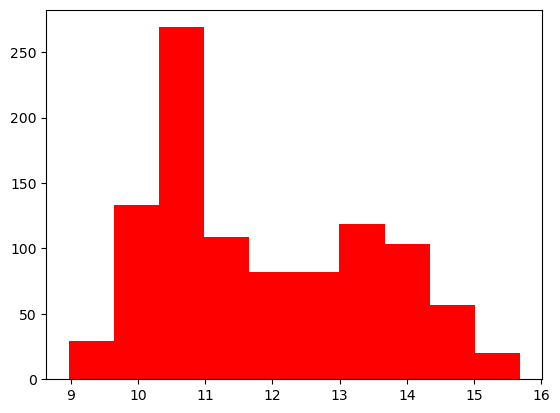

In [20]:
plt.hist(y_gt_10thgen, color = 'r', label = 'original')

# Greedy Exploration

In [70]:
# Let's start with selecting intial training dataset for all the cases
inputs = X_input_10thgen
outputs_abs = y_gt_10thgen
np.random.seed(12)
# We start by picking 10 random trajectorties as the initialization dataset
idx = np.random.choice(np.arange(len(inputs)), size = 10, replace = False)

In [71]:
inputs_train = inputs[idx]
inputs_unmeasured = np.delete(inputs, idx, axis=0)

indices_total = np.arange(len(inputs))
indices_train = indices_total[idx]
y_train = outputs_abs[idx]
indices_unmeasured = np.delete(indices_total, idx)

print(np.min(outputs_abs), np.max(outputs_abs))
print(np.min(y_train), np.max(y_train))

8.97330506704132 15.678448096484642
9.642672425172417 11.78337136341413


In [72]:
exploration_steps = 10
for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key, pred_key = gpax.utils.get_keys()
    dkl_BO = gpax.viDKL(900, 2, 'RBF')
    dkl_BO.fit(rng_key, inputs_train, y_train, nn = CustomCNN, num_steps = 10000, step_size = 5e-4)
    # Compute acqusition function
    y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        pred_key, inputs_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean  # UCB = mu + 10 * sigma

    sort = np.argsort(obj)[::-1]
    # Get the next 5 points to evaluate
    ids_next = sort[0:10]

    x_next = inputs_unmeasured[ids_next]
    inds_next = indices_unmeasured[ids_next]
    
    
    # run simulation to get the ground truth
    y_measured = outputs_abs[inds_next]

    # Update training arrays
    inputs_train = np.append(inputs_train, x_next, axis=0)
    y_train = np.append(y_train, y_measured)
    inputs_unmeasured = np.delete(inputs_unmeasured, ids_next, axis=0)
    indices_unmeasured = np.delete(indices_unmeasured, ids_next)


Step 1


100%|█| 10000/10000 [00:11<00:00, 891.64it/s, init loss: 60353.2826, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.31  ]
k_scale          13.5892
noise            0.101

Step 2


100%|█| 10000/10000 [00:11<00:00, 880.25it/s, init loss: 60720.8366, avg. loss [



Inferred GP kernel parameters
k_length         [0.3543 0.351 ]
k_scale          14.5618
noise            0.10260000000000001

Step 3


100%|█| 10000/10000 [00:11<00:00, 859.67it/s, init loss: 61180.0247, avg. loss [



Inferred GP kernel parameters
k_length         [0.5323 0.5549]
k_scale          14.2077
noise            0.06670000000000001

Step 4


100%|█| 10000/10000 [00:14<00:00, 694.34it/s, init loss: 61564.4593, avg. loss [



Inferred GP kernel parameters
k_length         [1.195  1.1638]
k_scale          13.7809
noise            0.055

Step 5


100%|█| 10000/10000 [00:15<00:00, 653.86it/s, init loss: 61961.3434, avg. loss [



Inferred GP kernel parameters
k_length         [1.3877 1.7732]
k_scale          12.9578
noise            0.0509

Step 6


100%|█| 10000/10000 [00:19<00:00, 518.02it/s, init loss: 62306.2375, avg. loss [



Inferred GP kernel parameters
k_length         [1.6074 1.6306]
k_scale          11.877600000000001
noise            0.0448

Step 7


100%|█| 10000/10000 [00:23<00:00, 428.87it/s, init loss: 62528.4133, avg. loss [



Inferred GP kernel parameters
k_length         [2.3945 1.5803]
k_scale          12.235100000000001
noise            0.0368

Step 8


100%|█| 10000/10000 [00:24<00:00, 407.54it/s, init loss: 62776.6489, avg. loss [



Inferred GP kernel parameters
k_length         [1.9988 2.6368]
k_scale          12.549100000000001
noise            0.0344

Step 9


100%|█| 10000/10000 [00:25<00:00, 394.49it/s, init loss: 63030.3529, avg. loss [



Inferred GP kernel parameters
k_length         [2.7757 2.4589]
k_scale          11.4486
noise            0.029500000000000002

Step 10


100%|█| 10000/10000 [00:27<00:00, 367.15it/s, init loss: 63231.2145, avg. loss [



Inferred GP kernel parameters
k_length         [2.9389 2.3315]
k_scale          11.602300000000001
noise            0.0328


In [73]:
y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs, batch_size=64)
y_std = jnp.sqrt(y_var)

y_mean_train, y_var_train = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs_train, batch_size=64)
y_std_train = jnp.sqrt(y_var_train)

rmse = np.sqrt(np.mean((outputs_abs - np.array(y_mean)) ** 2))

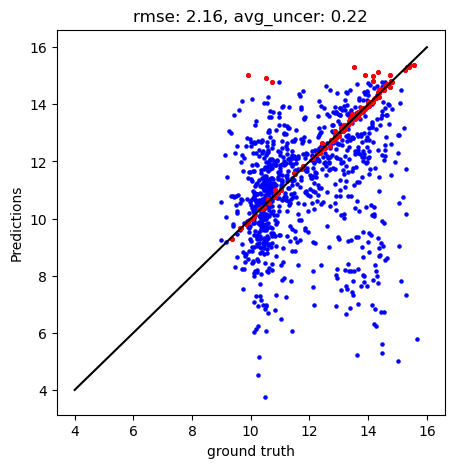

In [74]:
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(outputs_abs, np.array(y_mean), c = 'b', s = 5)
ax.scatter(y_train, np.array(y_mean_train), c = 'r', s = 7)
ax.plot(np.linspace(4, 16, 100), np.linspace(4, 16, 100), c = 'k')
ax.set_xlabel('ground truth')
ax.set_ylabel('Predictions')
ax.set_title('rmse: {:.2f}, avg_uncer: {:.2f}'.format(rmse, np.mean(np.array(y_std))))

plt.savefig('policy1_mean.png', dpi = 300)

# Uncertainty Based

In [78]:
# Let's start with selecting intial training dataset for all the cases
inputs = X_input_10thgen
outputs_abs = y_gt_10thgen
np.random.seed(12)
# We start by picking 10 random trajectorties as the initialization dataset
idx = np.random.choice(np.arange(len(inputs)), size = 10, replace = False)

In [79]:
inputs_train = inputs[idx]
inputs_unmeasured = np.delete(inputs, idx, axis=0)

indices_total = np.arange(len(inputs))
indices_train = indices_total[idx]
y_train = outputs_abs[idx]
indices_unmeasured = np.delete(indices_total, idx)

print(np.min(outputs_abs), np.max(outputs_abs))
print(np.min(y_train), np.max(y_train))

8.97330506704132 15.678448096484642
9.642672425172417 11.78337136341413


In [80]:
exploration_steps = 10
for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key, pred_key = gpax.utils.get_keys()
    dkl_BO = gpax.viDKL(900, 2, 'RBF')
    dkl_BO.fit(rng_key, inputs_train, y_train, nn = CustomCNN, num_steps = 10000, step_size = 5e-4)
    # Compute acqusition function
    y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        pred_key, inputs_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_std  # UCB = mu + 10 * sigma

    sort = np.argsort(obj)[::-1]
    # Get the next 5 points to evaluate
    ids_next = sort[0:10]

    x_next = inputs_unmeasured[ids_next]
    inds_next = indices_unmeasured[ids_next]
    
    
    # run simulation to get the ground truth
    y_measured = outputs_abs[inds_next]

    # Update training arrays
    inputs_train = np.append(inputs_train, x_next, axis=0)
    y_train = np.append(y_train, y_measured)
    inputs_unmeasured = np.delete(inputs_unmeasured, ids_next, axis=0)
    indices_unmeasured = np.delete(indices_unmeasured, ids_next)


Step 1


100%|█| 10000/10000 [00:11<00:00, 888.28it/s, init loss: 60353.2826, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.31  ]
k_scale          13.5892
noise            0.101

Step 2


100%|█| 10000/10000 [00:11<00:00, 884.05it/s, init loss: 60712.4502, avg. loss [



Inferred GP kernel parameters
k_length         [0.7753 0.5839]
k_scale          16.716900000000003
noise            0.08080000000000001

Step 3


100%|█| 10000/10000 [00:12<00:00, 810.33it/s, init loss: 61040.8910, avg. loss [



Inferred GP kernel parameters
k_length         [0.6996 0.6625]
k_scale          14.3506
noise            0.1361

Step 4


100%|█| 10000/10000 [00:14<00:00, 688.14it/s, init loss: 61336.1142, avg. loss [



Inferred GP kernel parameters
k_length         [1.2257 1.1195]
k_scale          13.425500000000001
noise            0.07640000000000001

Step 5


100%|█| 10000/10000 [00:15<00:00, 640.21it/s, init loss: 61665.1661, avg. loss [



Inferred GP kernel parameters
k_length         [2.2636 1.5832]
k_scale          12.5935
noise            0.08560000000000001

Step 6


100%|█| 10000/10000 [00:19<00:00, 523.16it/s, init loss: 61994.5387, avg. loss [



Inferred GP kernel parameters
k_length         [2.5149 1.8645]
k_scale          11.6174
noise            0.083

Step 7


100%|█| 10000/10000 [00:21<00:00, 457.51it/s, init loss: 62257.5979, avg. loss [



Inferred GP kernel parameters
k_length         [2.6068 1.9274]
k_scale          11.876000000000001
noise            0.0729

Step 8


100%|█| 10000/10000 [00:22<00:00, 440.64it/s, init loss: 62512.3037, avg. loss [



Inferred GP kernel parameters
k_length         [4.0146 2.5734]
k_scale          11.144300000000001
noise            0.0656

Step 9


100%|█| 10000/10000 [00:23<00:00, 423.13it/s, init loss: 62828.0393, avg. loss [



Inferred GP kernel parameters
k_length         [3.3307 3.7075]
k_scale          10.3369
noise            0.0512

Step 10


100%|█| 10000/10000 [00:24<00:00, 404.67it/s, init loss: 63016.0649, avg. loss [



Inferred GP kernel parameters
k_length         [3.3229 4.5911]
k_scale          10.8163
noise            0.0465


In [81]:
y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs, batch_size=64)
y_std = jnp.sqrt(y_var)

y_mean_train, y_var_train = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs_train, batch_size=64)
y_std_train = jnp.sqrt(y_var_train)

rmse = np.sqrt(np.mean((outputs_abs - np.array(y_mean)) ** 2))

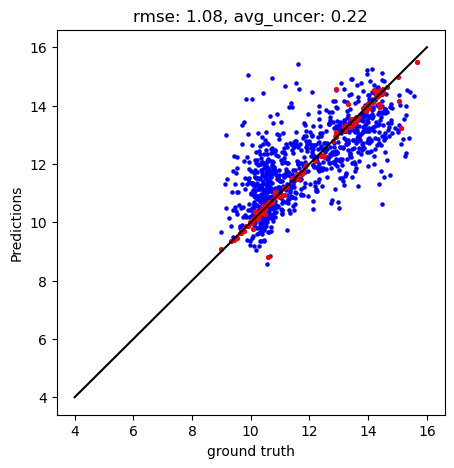

In [82]:
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(outputs_abs, np.array(y_mean), c = 'b', s = 5)
ax.scatter(y_train, np.array(y_mean_train), c = 'r', s = 7)
ax.plot(np.linspace(4, 16, 100), np.linspace(4, 16, 100), c = 'k')
ax.set_xlabel('ground truth')
ax.set_ylabel('Predictions')
ax.set_title('rmse: {:.2f}, avg_uncer: {:.2f}'.format(rmse, np.mean(np.array(y_std))))

plt.savefig('policy1_std.png', dpi = 300)

# UCB Exploration

In [83]:
# Let's start with selecting intial training dataset for all the cases
inputs = X_input_10thgen
outputs_abs = y_gt_10thgen
np.random.seed(12)
# We start by picking 10 random trajectorties as the initialization dataset
idx = np.random.choice(np.arange(len(inputs)), size = 10, replace = False)

In [84]:
inputs_train = inputs[idx]
inputs_unmeasured = np.delete(inputs, idx, axis=0)

indices_total = np.arange(len(inputs))
indices_train = indices_total[idx]
y_train = outputs_abs[idx]
indices_unmeasured = np.delete(indices_total, idx)

print(np.min(outputs_abs), np.max(outputs_abs))
print(np.min(y_train), np.max(y_train))

8.97330506704132 15.678448096484642
9.642672425172417 11.78337136341413


In [85]:
exploration_steps = 10
for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key, pred_key = gpax.utils.get_keys()
    dkl_BO = gpax.viDKL(900, 2, 'RBF')
    dkl_BO.fit(rng_key, inputs_train, y_train, nn = CustomCNN, num_steps = 10000, step_size = 5e-4)
    # Compute acqusition function
    y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        pred_key, inputs_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10*y_std  # UCB = mu + 10 * sigma

    sort = np.argsort(obj)[::-1]
    # Get the next 5 points to evaluate
    ids_next = sort[0:10]

    x_next = inputs_unmeasured[ids_next]
    inds_next = indices_unmeasured[ids_next]
    
    
    # run simulation to get the ground truth
    y_measured = outputs_abs[inds_next]

    # Update training arrays
    inputs_train = np.append(inputs_train, x_next, axis=0)
    y_train = np.append(y_train, y_measured)
    inputs_unmeasured = np.delete(inputs_unmeasured, ids_next, axis=0)
    indices_unmeasured = np.delete(indices_unmeasured, ids_next)


Step 1


100%|█| 10000/10000 [00:09<00:00, 1040.29it/s, init loss: 60353.2826, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.31  ]
k_scale          13.5892
noise            0.101

Step 2


100%|█| 10000/10000 [00:11<00:00, 869.67it/s, init loss: 60730.8093, avg. loss [



Inferred GP kernel parameters
k_length         [0.5315 0.5158]
k_scale          16.7132
noise            0.1057

Step 3


100%|█| 10000/10000 [00:12<00:00, 823.50it/s, init loss: 61116.3258, avg. loss [



Inferred GP kernel parameters
k_length         [0.8412 0.8897]
k_scale          13.9876
noise            0.1598

Step 4


100%|█| 10000/10000 [00:14<00:00, 693.54it/s, init loss: 61607.1227, avg. loss [



Inferred GP kernel parameters
k_length         [1.03  1.195]
k_scale          11.603200000000001
noise            0.14500000000000002

Step 5


100%|█| 10000/10000 [00:15<00:00, 640.80it/s, init loss: 62000.4897, avg. loss [



Inferred GP kernel parameters
k_length         [2.496  2.0879]
k_scale          11.9778
noise            0.062

Step 6


100%|█| 10000/10000 [00:19<00:00, 502.19it/s, init loss: 62354.2030, avg. loss [



Inferred GP kernel parameters
k_length         [2.1372 1.6893]
k_scale          11.468900000000001
noise            0.0682

Step 7


100%|█| 10000/10000 [00:24<00:00, 401.73it/s, init loss: 62665.8457, avg. loss [



Inferred GP kernel parameters
k_length         [1.9503 2.6004]
k_scale          11.0174
noise            0.08370000000000001

Step 8


100%|█| 10000/10000 [00:25<00:00, 397.03it/s, init loss: 62865.5246, avg. loss [



Inferred GP kernel parameters
k_length         [2.7892 3.3297]
k_scale          11.075000000000001
noise            0.0455

Step 9


100%|█| 10000/10000 [00:27<00:00, 361.99it/s, init loss: 63067.8618, avg. loss [



Inferred GP kernel parameters
k_length         [3.3073 2.9725]
k_scale          10.7947
noise            0.040400000000000005

Step 10


100%|█| 10000/10000 [00:29<00:00, 338.97it/s, init loss: 63356.4845, avg. loss [



Inferred GP kernel parameters
k_length         [4.0248 2.5877]
k_scale          10.8971
noise            0.0407


In [86]:
y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs, batch_size=64)
y_std = jnp.sqrt(y_var)

y_mean_train, y_var_train = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs_train, batch_size=64)
y_std_train = jnp.sqrt(y_var_train)

rmse = np.sqrt(np.mean((outputs_abs - np.array(y_mean)) ** 2))

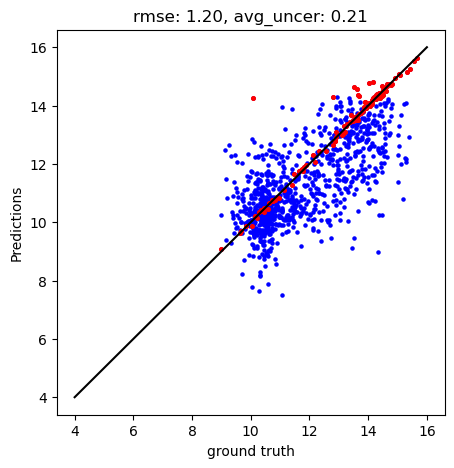

In [87]:
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(outputs_abs, np.array(y_mean), c = 'b', s = 5)
ax.scatter(y_train, np.array(y_mean_train), c = 'r', s = 7)
ax.plot(np.linspace(4, 16, 100), np.linspace(4, 16, 100), c = 'k')
ax.set_xlabel('ground truth')
ax.set_ylabel('Predictions')
ax.set_title('rmse: {:.2f}, avg_uncer: {:.2f}'.format(rmse, np.mean(np.array(y_std))))

plt.savefig('policy1_ucb.png', dpi = 300)

# EI Exploration

In [104]:
# Let's start with selecting intial training dataset for all the cases
inputs = X_input_10thgen
outputs_abs = y_gt_10thgen
np.random.seed(12)
# We start by picking 10 random trajectorties as the initialization dataset
idx = np.random.choice(np.arange(len(inputs)), size = 10, replace = False)

In [105]:
inputs_train = inputs[idx]
inputs_unmeasured = np.delete(inputs, idx, axis=0)

indices_total = np.arange(len(inputs))
indices_train = indices_total[idx]
y_train = outputs_abs[idx]
indices_unmeasured = np.delete(indices_total, idx)

print(np.min(outputs_abs), np.max(outputs_abs))
print(np.min(y_train), np.max(y_train))

8.97330506704132 15.678448096484642
9.642672425172417 11.78337136341413


In [106]:
exploration_steps = 10
for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key, pred_key = gpax.utils.get_keys()
    dkl_BO = gpax.viDKL(900, 2, 'RBF')
    dkl_BO.fit(rng_key, inputs_train, y_train, nn = CustomCNN, num_steps = 10000, step_size = 5e-4)
    # Compute acqusition function
    y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        pred_key, inputs_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)

    # EI aacquisition function
    obj = gpax.acquisition.EI(pred_key,
        dkl_BO,
        inputs_unmeasured,
        best_f = np.max(y_train),
        n = 12,
        maximize=True,
        noiseless=True
    )

    sort = np.argsort(obj)[::-1]
    # Get the next 5 points to evaluate
    ids_next = sort[0:10]

    x_next = inputs_unmeasured[ids_next]
    inds_next = indices_unmeasured[ids_next]
    
    
    # run simulation to get the ground truth
    y_measured = outputs_abs[inds_next]

    # Update training arrays
    inputs_train = np.append(inputs_train, x_next, axis=0)
    y_train = np.append(y_train, y_measured)
    inputs_unmeasured = np.delete(inputs_unmeasured, ids_next, axis=0)
    indices_unmeasured = np.delete(indices_unmeasured, ids_next)


Step 1


100%|█| 10000/10000 [00:09<00:00, 1042.59it/s, init loss: 60353.2826, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.31  ]
k_scale          13.5892
noise            0.101

Step 2


100%|█| 10000/10000 [00:11<00:00, 895.30it/s, init loss: 60693.8223, avg. loss [



Inferred GP kernel parameters
k_length         [0.352  0.3886]
k_scale          15.1165
noise            0.0863

Step 3


100%|█| 10000/10000 [00:12<00:00, 814.22it/s, init loss: 61080.9071, avg. loss [



Inferred GP kernel parameters
k_length         [0.4388 0.4693]
k_scale          13.2088
noise            0.12010000000000001

Step 4


100%|█| 10000/10000 [00:14<00:00, 695.81it/s, init loss: 61511.4145, avg. loss [



Inferred GP kernel parameters
k_length         [1.0474 0.6645]
k_scale          11.7629
noise            0.0848

Step 5


100%|█| 10000/10000 [00:15<00:00, 663.46it/s, init loss: 61881.7087, avg. loss [



Inferred GP kernel parameters
k_length         [1.4423 0.9595]
k_scale          11.531400000000001
noise            0.0748

Step 6


100%|█| 10000/10000 [00:18<00:00, 537.08it/s, init loss: 62212.6233, avg. loss [



Inferred GP kernel parameters
k_length         [1.7932 2.7166]
k_scale          10.956100000000001
noise            0.050800000000000005

Step 7


100%|█| 10000/10000 [00:22<00:00, 453.62it/s, init loss: 62595.4053, avg. loss [



Inferred GP kernel parameters
k_length         [2.9574 1.8933]
k_scale          11.4626
noise            0.0616

Step 8


100%|█| 10000/10000 [00:22<00:00, 452.35it/s, init loss: 62885.7909, avg. loss [



Inferred GP kernel parameters
k_length         [3.2994 3.2782]
k_scale          10.5325
noise            0.056400000000000006

Step 9


100%|█| 10000/10000 [00:22<00:00, 442.17it/s, init loss: 63176.9411, avg. loss [



Inferred GP kernel parameters
k_length         [3.5229 3.1774]
k_scale          10.307
noise            0.049600000000000005

Step 10


100%|█| 10000/10000 [00:24<00:00, 401.65it/s, init loss: 63498.7977, avg. loss [



Inferred GP kernel parameters
k_length         [2.8966 2.6337]
k_scale          13.2779
noise            0.0454


In [107]:
y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs, batch_size=64)
y_std = jnp.sqrt(y_var)

y_mean_train, y_var_train = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs_train, batch_size=64)
y_std_train = jnp.sqrt(y_var_train)

rmse = np.sqrt(np.mean((outputs_abs - np.array(y_mean)) ** 2))

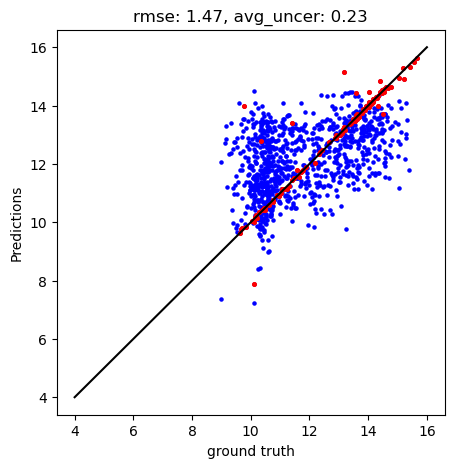

In [108]:
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(outputs_abs, np.array(y_mean), c = 'b', s = 5)
ax.scatter(y_train, np.array(y_mean_train), c = 'r', s = 7)
ax.plot(np.linspace(4, 16, 100), np.linspace(4, 16, 100), c = 'k')
ax.set_xlabel('ground truth')
ax.set_ylabel('Predictions')
ax.set_title('rmse: {:.2f}, avg_uncer: {:.2f}'.format(rmse, np.mean(np.array(y_std))))

plt.savefig('policy1_ei.png', dpi = 300)

# POI Exploration

In [109]:
# Let's start with selecting intial training dataset for all the cases
inputs = X_input_10thgen
outputs_abs = y_gt_10thgen
np.random.seed(12)
# We start by picking 10 random trajectorties as the initialization dataset
idx = np.random.choice(np.arange(len(inputs)), size = 10, replace = False)

In [110]:
inputs_train = inputs[idx]
inputs_unmeasured = np.delete(inputs, idx, axis=0)

indices_total = np.arange(len(inputs))
indices_train = indices_total[idx]
y_train = outputs_abs[idx]
indices_unmeasured = np.delete(indices_total, idx)

print(np.min(outputs_abs), np.max(outputs_abs))
print(np.min(y_train), np.max(y_train))

8.97330506704132 15.678448096484642
9.642672425172417 11.78337136341413


In [111]:
exploration_steps = 10
for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key, pred_key = gpax.utils.get_keys()
    dkl_BO = gpax.viDKL(900, 2, 'RBF')
    dkl_BO.fit(rng_key, inputs_train, y_train, nn = CustomCNN, num_steps = 10000, step_size = 5e-4)
    # Compute acqusition function
    y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        pred_key, inputs_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)

    # EI aacquisition function
    obj = gpax.acquisition.POI(pred_key,
        dkl_BO,
        inputs_unmeasured,
        best_f = np.max(y_train),
        n = 12,
        maximize=True,
        noiseless=True
    )

    sort = np.argsort(obj)[::-1]
    # Get the next 5 points to evaluate
    ids_next = sort[0:10]

    x_next = inputs_unmeasured[ids_next]
    inds_next = indices_unmeasured[ids_next]
    
    
    # run simulation to get the ground truth
    y_measured = outputs_abs[inds_next]

    # Update training arrays
    inputs_train = np.append(inputs_train, x_next, axis=0)
    y_train = np.append(y_train, y_measured)
    inputs_unmeasured = np.delete(inputs_unmeasured, ids_next, axis=0)
    indices_unmeasured = np.delete(indices_unmeasured, ids_next)


Step 1


100%|█| 10000/10000 [00:09<00:00, 1044.67it/s, init loss: 60353.2826, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.31  ]
k_scale          13.5892
noise            0.101

Step 2


100%|█| 10000/10000 [00:11<00:00, 901.36it/s, init loss: 60710.3247, avg. loss [



Inferred GP kernel parameters
k_length         [0.369  0.3425]
k_scale          14.6195
noise            0.0782

Step 3


100%|█| 10000/10000 [00:11<00:00, 882.67it/s, init loss: 61127.5825, avg. loss [



Inferred GP kernel parameters
k_length         [0.7614 0.8568]
k_scale          14.4747
noise            0.1101

Step 4


100%|█| 10000/10000 [00:13<00:00, 718.57it/s, init loss: 61489.9243, avg. loss [



Inferred GP kernel parameters
k_length         [1.2904 1.3818]
k_scale          13.0645
noise            0.0689

Step 5


100%|█| 10000/10000 [00:15<00:00, 631.76it/s, init loss: 61775.5194, avg. loss [



Inferred GP kernel parameters
k_length         [1.4371 2.0003]
k_scale          11.6118
noise            0.08320000000000001

Step 6


100%|█| 10000/10000 [00:19<00:00, 503.98it/s, init loss: 62188.3863, avg. loss [



Inferred GP kernel parameters
k_length         [2.4975 1.8189]
k_scale          10.9623
noise            0.0718

Step 7


100%|█| 10000/10000 [00:24<00:00, 408.27it/s, init loss: 62614.1333, avg. loss [



Inferred GP kernel parameters
k_length         [3.1598 2.0924]
k_scale          11.5466
noise            0.0512

Step 8


100%|█| 10000/10000 [00:25<00:00, 391.41it/s, init loss: 62982.0137, avg. loss [



Inferred GP kernel parameters
k_length         [2.9793 2.797 ]
k_scale          12.555100000000001
noise            0.053200000000000004

Step 9


100%|█| 10000/10000 [00:26<00:00, 378.66it/s, init loss: 63249.1320, avg. loss [



Inferred GP kernel parameters
k_length         [2.4231 2.6711]
k_scale          12.6462
noise            0.0543

Step 10


100%|█| 10000/10000 [00:29<00:00, 336.08it/s, init loss: 63428.9066, avg. loss [



Inferred GP kernel parameters
k_length         [3.025  1.6739]
k_scale          14.9069
noise            0.0475


In [112]:
y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs, batch_size=64)
y_std = jnp.sqrt(y_var)

y_mean_train, y_var_train = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs_train, batch_size=64)
y_std_train = jnp.sqrt(y_var_train)

rmse = np.sqrt(np.mean((outputs_abs - np.array(y_mean)) ** 2))

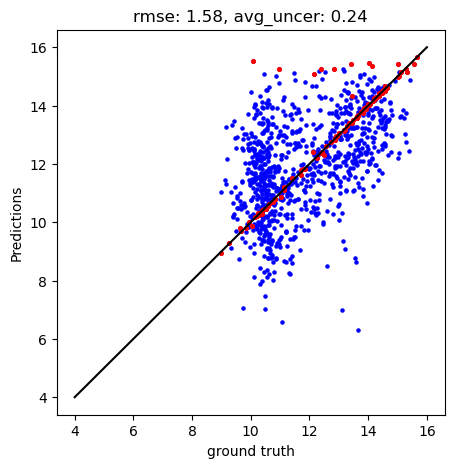

In [113]:
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(outputs_abs, np.array(y_mean), c = 'b', s = 5)
ax.scatter(y_train, np.array(y_mean_train), c = 'r', s = 7)
ax.plot(np.linspace(4, 16, 100), np.linspace(4, 16, 100), c = 'k')
ax.set_xlabel('ground truth')
ax.set_ylabel('Predictions')
ax.set_title('rmse: {:.2f}, avg_uncer: {:.2f}'.format(rmse, np.mean(np.array(y_std))))

plt.savefig('policy1_poi.png', dpi = 300)